## Daniel Burke Etivity3 Regression
12067717

Task Two: Regression

Requirements:

- For each regressor, include data preparation and dimensionality reduction steps in the main pipeline.

- You can choose any regressor as the third one. Some options are SVR and MLPRegressor, but you are not limited to them.

- For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.

- Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-2 - Regression and Dimensionality Reduction.ipynb to evaluate and compare the models you have trained and pick the best one.

- Summarise your experience in a markdown cell (max 150 words in a markdown cell).

In [1]:
#A. Import Python Modules and Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.model_selection import train_test_split, GridSearchCV

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn import set_config
current_palette = sns.color_palette('pastel')

In [2]:
# https://www.kaggle.com/datasets/mirichoi0218/insurance 

# Load the dataset
df = pd.read_csv("./insurance.csv")
df_original = df.copy() # make a copy

# first inspection of the data
print('      Dataset      ')
print('------------------------')
print(f'Number of samples   : {df.shape[0]}')
print(f'Number of attributes: {df.shape[1]}')
print()

      Dataset      
------------------------
Number of samples   : 1338
Number of attributes: 7



### Columns / Features

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

### EDA - Exploratory Data Analysis

In [3]:
# discretize the age column values into bins of decades.
bins = [10, 20, 30, 40, 50, 60, 70]
labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70']
df['age_bin'] = pd.cut(df['age'], bins=bins, labels=False, right=False) # create new feature to replace old one

# Adjust the labels for ages 18 and 19 to include them in the '20-30' bin
df.loc[df['age'].between(18, 19), 'age_bin'] = labels.index('20-30')
df.drop(columns=['age'], inplace=True)

FEATURES = list(df.columns.values)
print(FEATURES)

CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
print(CATEGORICAL_FEATURES)

NUMERICAL_FEATURES = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(NUMERICAL_FEATURES)

df.info()

['gender', 'bmi', 'children', 'smoker', 'region', 'insurance_cost', 'age_bin']
['gender', 'smoker', 'region']
['bmi', 'children', 'insurance_cost', 'age_bin']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          1338 non-null   object 
 1   bmi             1338 non-null   float64
 2   children        1338 non-null   int64  
 3   smoker          1338 non-null   object 
 4   region          1338 non-null   object 
 5   insurance_cost  1338 non-null   float64
 6   age_bin         1338 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


There is no need to impute values here or deal with missing data.

In [4]:
df.describe().T

count          mean           std        min         25%  \
bmi             1338.0     30.663397      6.098187    15.9600    26.29625   
children        1338.0      1.094918      1.205493     0.0000     0.00000   
insurance_cost  1338.0  13270.422265  12110.011237  1121.8739  4740.28715   
age_bin         1338.0      2.557549      1.337025     1.0000     1.00000   

                     50%           75%          max  
bmi               30.400     34.693750     53.13000  
children           1.000      2.000000      5.00000  
insurance_cost  9382.033  16639.912515  63770.42801  
age_bin            2.000      4.000000      5.00000

In [5]:
df.describe(include=['object']) #describing the categorical varibles

gender smoker     region
count    1338   1338       1338
unique      2      2          4
top      male     no  southeast
freq      676   1064        364

In [6]:
# a quick look at the numerical features
plt.figure(figsize=(6, 4))
for i, FEATURE in enumerate(NUMERICAL_FEATURES, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[FEATURE], kde=True, stat="count", linewidth=0.5, color=current_palette[i-1])
    plt.tight_layout()

plt.show()

skewness = df.skew(numeric_only=True)
kurtosis = df.kurtosis(numeric_only=True)
pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})

Skewness  Kurtosis
bmi             0.284047 -0.050732
children        0.938380  0.202454
insurance_cost  1.515880  1.606299
age_bin         0.275278 -1.191760

In [7]:
# a boxplot look at the numerical features
plt.figure(figsize=(6, 4))
for i, FEATURE in enumerate(NUMERICAL_FEATURES, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[FEATURE], palette=current_palette)
    plt.title(FEATURE)
    plt.tight_layout()

plt.show()

The column here with the highest number of outliers is the insurance_cost. This is going to be the target variable for the regression in this etivity so I am going to be using it for testing, so I do not need to worry about trying to treat the number of outliers or dealing with it's skew which is large.

In [8]:
# map binary values
smoker_dict = {'yes': 1, 'no': 0}
df['smoker'] = df['smoker'].replace(smoker_dict)
gender_dict = {'male': 1, 'female': 0}
df['gender'] = df['gender'].replace(gender_dict)

In [9]:
# categorical features as a dataframe & total number of null values.
value_counts_df = pd.DataFrame(columns=['Feature', 'Value', 'Count'])
data = []

for feature in CATEGORICAL_FEATURES:
    counts = df[feature].value_counts()
    
    for value, count in counts.items():
        
        data.append({'Feature': feature, 'Value': value, 'Count': count})

value_counts_df = pd.DataFrame(data)

print(value_counts_df.to_string(index=False))
df.isnull().sum()

Feature     Value  Count
 gender         1    676
 gender         0    662
 smoker         0   1064
 smoker         1    274
 region southeast    364
 region southwest    325
 region northwest    325
 region northeast    324


gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
age_bin           0
dtype: int64

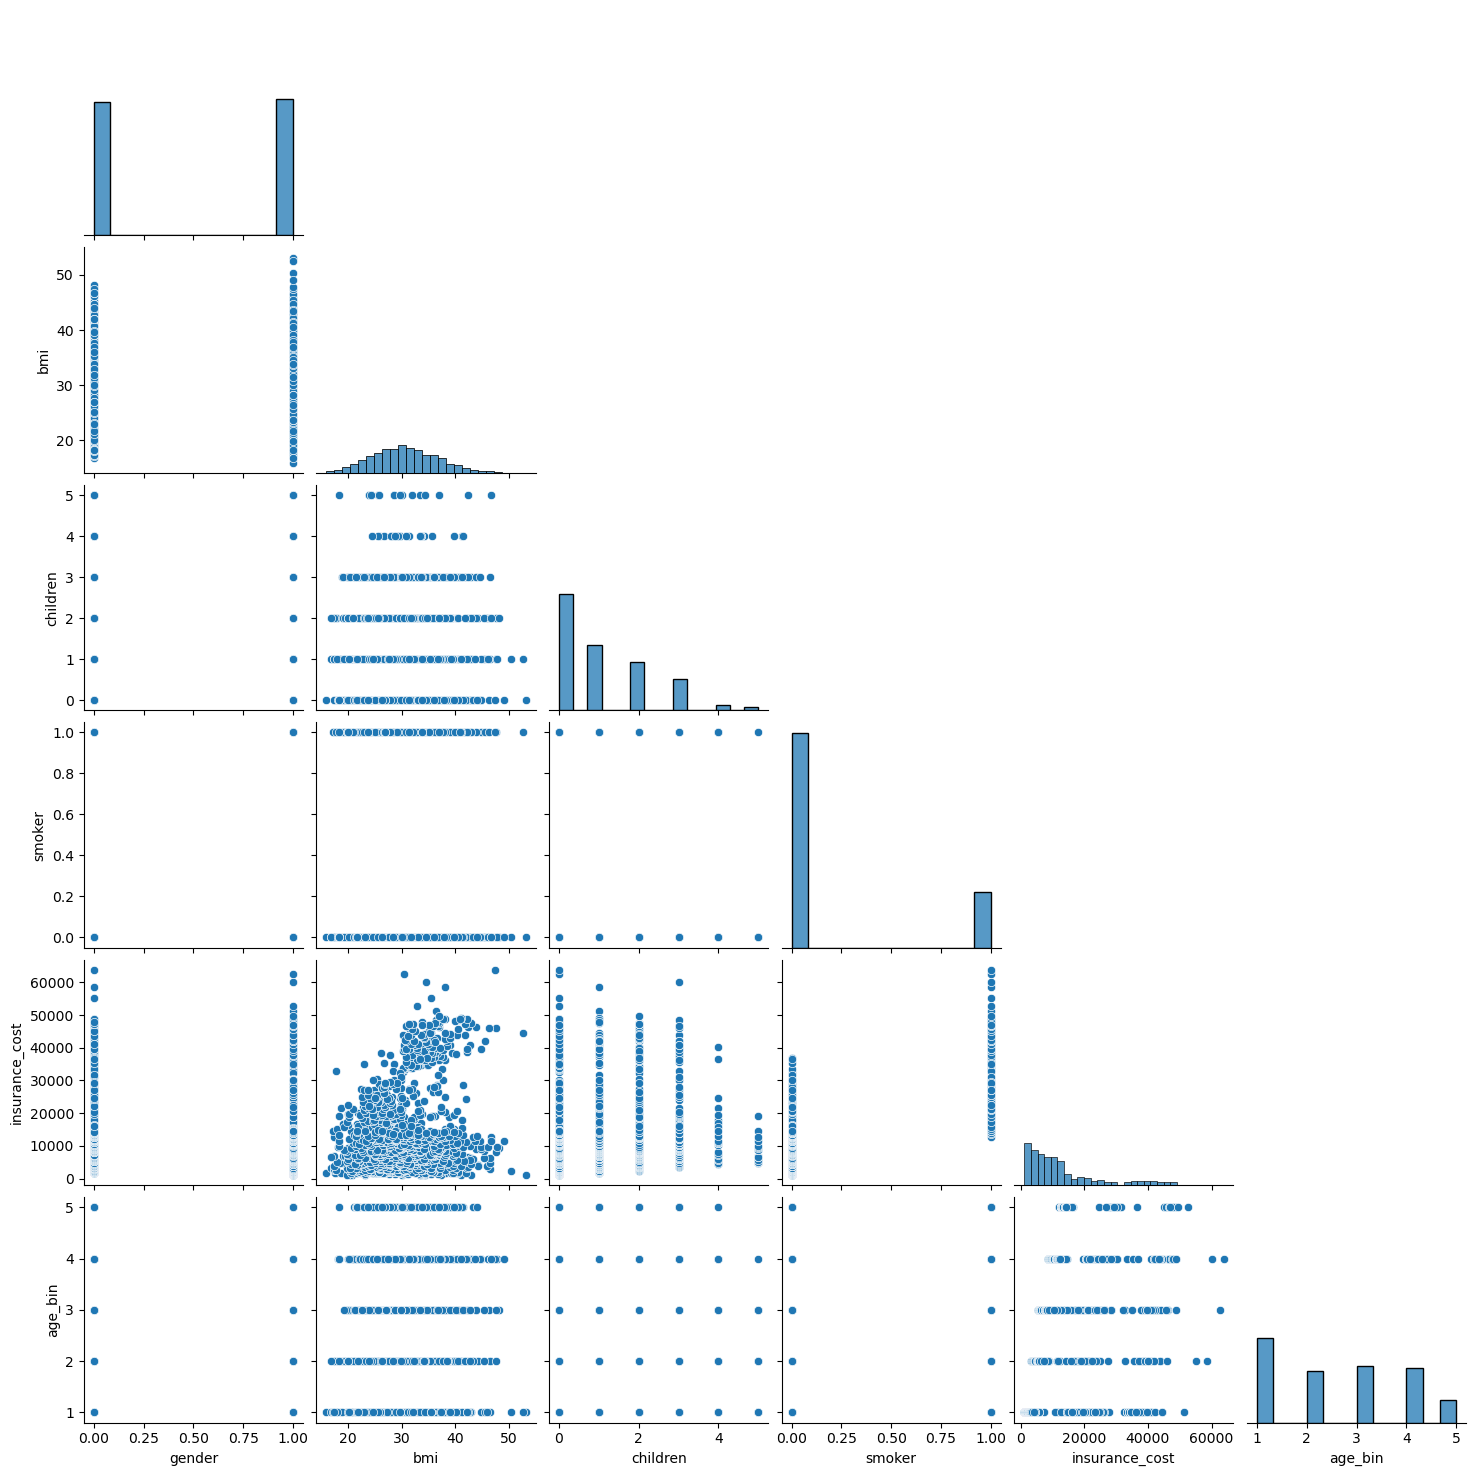

In [10]:
# plot the numeric columns but split by smoking - most interesting features along with #children
sns.pairplot(data=df, corner=True)
sns.pairplot(data=df, corner=True, hue="smoker")
sns.pairplot(data=df, corner=True, hue="children", palette=current_palette)
plt.show()

Just as in the classification example, the regions here seem to be equally distributed, although the BMI's show slightly different distributions for each region.

I do not see any reason why I should take a different approach to the dataset for this example compared to the last. There are a large number of outliers in the target feature, insurance_cost, but they are all acceptable and believable values for what insurance may be, our model will be a better model for leaving them in. The main difference between the last example and this one are here, with the binary encoding on the insurance_cost the last time, no smokers had a below average insurance cost. In this example we have a full distribution, and this column will be dropped later and used as our target variable.

| Feature | Total Count | Missing Count | Skew | Outliers | Encoding | Rescaling | Transform |
|:---|:---|---|---|:---|:---|:---|:---|
|gender|1338|0| | | binary |  | |
|bmi|1338|0| mild right| | | RobustScaler | log |
|children|1338|0| right| yes | | MinMaxScaler| cube root |
|smoker|1338|0| | | binary | | |
|region|1338|0| | | One-Hot | | |
|insurance_cost|1338|0| strong right| yes | target variable | | |
|age|1338|0| | | Discretized & Dropped | | |
| **new features** | | |  |  | | | |
| age_bin |1338|0| mild right |  | |  | |

### Data preparation and encoding

##### Numerical Features
* Due to the presence of a number of outliers in the numerical feature BMI, I am going to scale with RobustScaler. Robust scaler scales using the median and the Interquartile range, instead of the standard deviation / mean, which means it's a good choice in the presence of outliers. I am going to use a log transformer as I feel its best suited to tackle the distribution of values.

* I am going to use a cube transformer to transform the children feature due to its large skewness value of almost one, and because there are quite a few examples of people with zero children. I am going to use the Min/Max Scaler

* I am not going to change the insurance_cost column as it is the target variable and it will be dropped.

* The age feature has already been discretized and I am not going to change it any further (new feature).

Note: I am going to do all this work not already done in the pipeline.

##### Categorical Features
* I am going to One-hot Encode the region feature. I am going to do this in the pipeline. For some of the classifiers I have considered and am going to drop this feature (or set of features) as mentioned above.

* I have already binary fitted the gender and smoking features, before creating the pipeline.

##### Dimensionality Reduction / Feature Selection
Note: As is the last example, the feature which stands out as a candidate for feature selection is the region. I showed in the last example how after one hot encoding there were four features which were negatively correlated with each other. If and when I drop them it will be because feature selection seems necessary, and the work was already done to show how little an effect it was having on insurance cost.


In [11]:
# split the data into target and predictors
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)

In [12]:
y.info() # target
X.info() # predictors

<class 'pandas.core.series.Series'>
RangeIndex: 1338 entries, 0 to 1337
Series name: insurance_cost
Non-Null Count  Dtype  
--------------  -----  
1338 non-null   float64
dtypes: float64(1)
memory usage: 10.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    1338 non-null   int64  
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   int64  
 4   region    1338 non-null   object 
 5   age_bin   1338 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 62.8+ KB


In [13]:
# Prepare the pipeline for preprocessing

# group 1
columns_skewed = ['children']

# group 2
columns_outliers = ['bmi']

# group 3
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist() # just the regions left

# group 3: all other predictors
columns_no_outliers = [item for item in list(df.columns) 
                             if item not in columns_outliers and item not in columns_skewed
                             and item not in CATEGORICAL_FEATURES]

# verify the correct columns are selected
print(len(columns_no_outliers))
print(columns_no_outliers)

4
['gender', 'smoker', 'insurance_cost', 'age_bin']


In [14]:
# build the preprocessing pipeline using pipeline and columntransformer

# children column has high skew but no outliers # same as classification
skewed_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt, feature_names_out='one-to-one')),
        ("scaler", MinMaxScaler())                                                              # would simplescaler be better
    ]
)

# bmi column has outliers and also has mild skew # same as classification
outliers_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log, feature_names_out='one-to-one')),
        ("scaler", RobustScaler())
    ]
)

# I may drop these features in the various below pipelines.
cat_pipeline = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ]
)




## first Pipeline  - Random Forest Regression                                                    # same as classification
'''all of these are the same for now as I have not done any dimensional reduction'''
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("skewed", skewed_pipeline, columns_skewed),    
        ("outliers", outliers_pipeline, columns_outliers),
        ("onehot", cat_pipeline, CATEGORICAL_FEATURES)                                            # no feature selection
    ],
    remainder="passthrough"                                                                       # above three columns passed through
)                                                                                                 #.set_output(transform="pandas") 

# The output of preprocess_pipeline is set to "pandas", 
# so we can view the output of the pipeline as a dataframe with 
# the names of the columns. We do this just as a test in the next few cells. 
# Otherwise, the output would be a numpy array.

## second Pipeline - Linear Regression
preprocess_pipeline_lr = ColumnTransformer(
    transformers = [
        ("skewed", skewed_pipeline, columns_skewed),    
        ("outliers", outliers_pipeline, columns_outliers),
        #("onehot", cat_pipeline, CATEGORICAL_FEATURES)    
        ("onehot", 'drop', CATEGORICAL_FEATURES)                                                  # drop the categoricals - feature selection
    ],
    remainder="passthrough"                                                                       # above three columns passed through
)                                                                                                 #.set_output(transform="pandas") 

## third Pipeline - MLP
preprocess_pipeline_mlp = ColumnTransformer(
    transformers = [
        ("skewed", skewed_pipeline, columns_skewed),    
        ("outliers", outliers_pipeline, columns_outliers),
        ("onehot", cat_pipeline, CATEGORICAL_FEATURES)                                            # no feature selection
    ],
    remainder="passthrough"                                                                       # above three columns passed through
)                                                                                                 #.set_output(transform="pandas") 



In [15]:
# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [16]:
preprocess_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('skewed',
                                 Pipeline(steps=[('cubic_root_transform',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'cbrt'>)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['children']),
                                ('outliers',
                                 Pipeline(steps=[('log_transform',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>)),
                                                 ('scaler', RobustScaler())]),
                                 ['bmi']),
                                ('onehot',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['region'])])

In [17]:
# examine the preprocess_pipelines

# 9 features to work with if no feature selection

transformed_df_rf = pd.DataFrame(preprocess_pipeline.fit_transform(X), columns=preprocess_pipeline.get_feature_names_out())
transformed_df_rf


skewed__children  outliers__bmi  onehot__region_northeast  \
0             0.584804       0.379349                       0.0   
1             0.000000       0.414439                       0.0   
2             0.000000      -0.520701                       1.0   
3             0.736806       0.867785                       1.0   
4             0.000000       0.572306                       1.0   
...                ...            ...                       ...   
1333          0.736806       0.165298                       1.0   
1334          0.000000      -0.443376                       0.0   
1335          0.000000      -0.507698                       1.0   
1336          0.736806       0.705053                       0.0   
1337          0.000000      -0.889244                       0.0   

      onehot__region_northwest  onehot__region_southeast  \
0                          0.0                       1.0   
1                          0.0                       1.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
1333                       0.0                       0.0   
1334                       1.0                       0.0   
1335                       0.0                       0.0   
1336                       0.0                       1.0   
1337                       0.0                       1.0   

      onehot__region_southwest  remainder__gender  remainder__smoker  \
0                          0.0                1.0                0.0   
1                          0.0                1.0                0.0   
2                          0.0                0.0                0.0   
3                          0.0                0.0                0.0   
4                          0.0                0.0                0.0   
...                        ...                ...                ...   
1333                       0.0                0.0                0.0   
1334                       0.0                0.0                1.0   
1335                       0.0                1.0                0.0   
1336                       0.0                1.0                1.0   
1337                       0.0                1.0                1.0   

      remainder__age_bin  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    1.0  
...                  ...  
1333                 5.0  
1334                 5.0  
1335                 5.0  
1336                 5.0  
1337                 5.0  

[1338 rows x 9 columns]

In [18]:
# if using feature selection, only 5 features selected if REGION is dropped
transformed_df_lr = pd.DataFrame(preprocess_pipeline_lr.fit_transform(X), columns=preprocess_pipeline_lr.get_feature_names_out())
transformed_df_lr

skewed__children  outliers__bmi  remainder__gender  remainder__smoker  \
0             0.584804       0.379349                1.0                0.0   
1             0.000000       0.414439                1.0                0.0   
2             0.000000      -0.520701                0.0                0.0   
3             0.736806       0.867785                0.0                0.0   
4             0.000000       0.572306                0.0                0.0   
...                ...            ...                ...                ...   
1333          0.736806       0.165298                0.0                0.0   
1334          0.000000      -0.443376                0.0                1.0   
1335          0.000000      -0.507698                1.0                0.0   
1336          0.736806       0.705053                1.0                1.0   
1337          0.000000      -0.889244                1.0                1.0   

      remainder__age_bin  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    1.0  
...                  ...  
1333                 5.0  
1334                 5.0  
1335                 5.0  
1336                 5.0  
1337                 5.0  

[1338 rows x 5 columns]

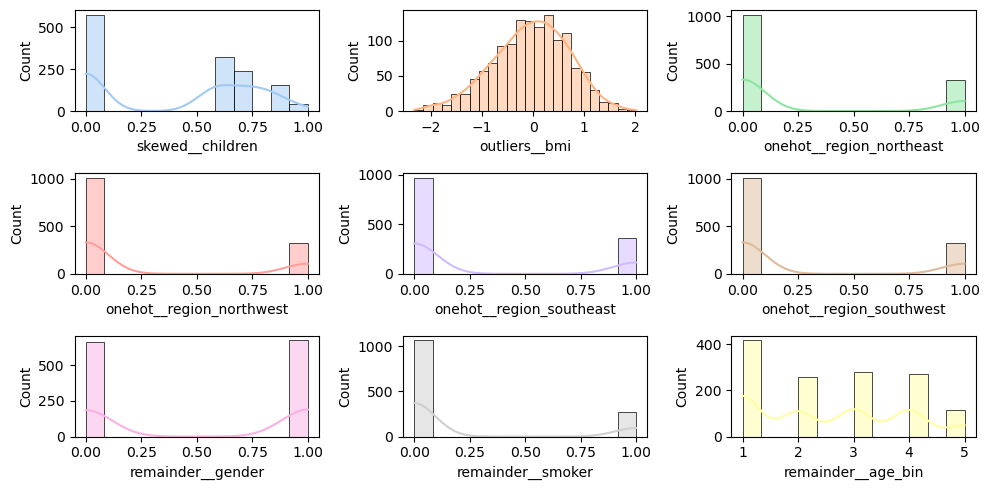

Skewness  Kurtosis
skewed__children         -0.097116 -1.745179
outliers__bmi            -0.256655 -0.134286
onehot__region_northeast  1.205161 -0.548410
onehot__region_northwest  1.200409 -0.559857
onehot__region_southeast  1.025621 -0.949523
onehot__region_southwest  1.200409 -0.559857
remainder__gender        -0.020951 -2.002557
remainder__smoker         1.464766  0.145756
remainder__age_bin        0.275278 -1.191760

In [19]:
'''plot the boxplots and histplots for the numerical features'''
NUMERICAL_FEATURES_TRANSFORMED = transformed_df_rf.select_dtypes(include=['int64', 'float64']).columns.to_list()
plt.figure(figsize=(10, 5))
for i, FEATURE in enumerate(NUMERICAL_FEATURES_TRANSFORMED, 1):
    plt.subplot(3, 3, i)
    sns.histplot(transformed_df_rf[FEATURE], kde=True, stat="count", linewidth=0.5, color=current_palette[i-1])
    plt.tight_layout()

plt.show()
skewness = transformed_df_rf.skew(numeric_only=True)
kurtosis = transformed_df_rf.kurtosis(numeric_only=True)
pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})

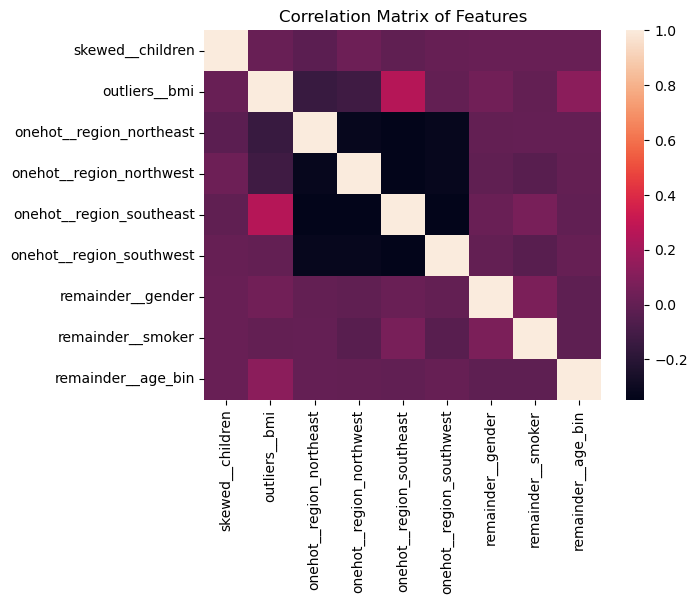

In [20]:
correlation_matrix = transformed_df_rf.corr()
sns.heatmap(correlation_matrix, cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

Note: This is a very similar result to the one in the classification example - one region (this time the southeast and not the northeast) is correlated with the target, and the rest are negatively correlated. I would suggest this is to do with the nature of binary encoding the last example to above/below the mean, but this is interesting nonetheless. It is something to consider when doing the feature selection.

In [21]:
transformed_df_rf['target'] = y # add back in the target

target                      1.000000
remainder__smoker           0.787251
remainder__age_bin          0.300066
outliers__bmi               0.199266
onehot__region_southeast    0.073982
skewed__children            0.072756
remainder__gender           0.057292
onehot__region_northeast    0.006349
onehot__region_northwest   -0.039905
onehot__region_southwest   -0.043210
Name: target, dtype: float64


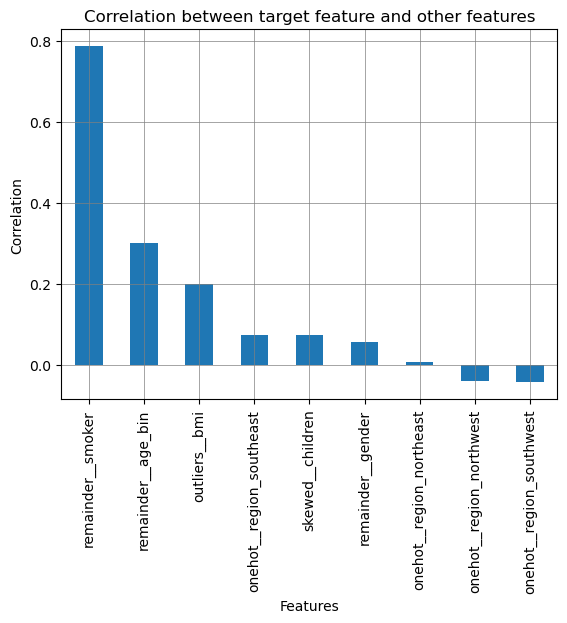

In [22]:
print(transformed_df_rf.corr()['target'].sort_values(ascending=False))

# continuing looking at the correlations
transformed_df_rf.corr()['target'].sort_values(ascending=False).drop('target').plot(kind='bar')

plt.title('Correlation between target feature and other features')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.grid(True, which='both', axis='both', linestyle='-', linewidth=0.5, color='gray')
plt.show()

After running the problem the first time and obtaining poor initial results, Linear Regression identified itself as having a potential need for feature selection. 

The correlation analysis shows that the region should be a candidate as the feature to be removed and was dropped from the dataset inside the pipeline. There is an argument to be made that one of the regions, the southeast is a high correlating feature and should be kept. If my results are very poor I will consider keeping this as the only region, through some sort of binary. I read in one of the other students work last week about their estimation that the South East region is important as this dataset is based in the UK, and the metro london area is playing a part in the bias or noise here. I am not sure what to think.

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Starting with Random Forest Regressor. I will use grid search to find the best performing hyperparameters, and cross-validation.

Again, I will build three pipelines, so that I can then add in dimensionality reduction using PCA, RF, and afterwards, feature selection where I outright drop the feature in the pipeline.

### Random Forest Pipeline

In [23]:
# prepare pipeline for RandomForestRegressor
pipe = Pipeline(steps=
                [('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['children']),
                                                 ('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['region'])])),
                ('reduce_dim', 'passthrough'),
                ('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(n_estimators=10)))])

In [24]:
# prepare a parameter grid for RandomForestRegressor

N_FEATURES_OPTIONS = [1, 2, 3, 4, 5, 6, 7, 8, 9] # 9 features is the full dataset
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {   # Dimensionality Reduction - PCA
        'reduce_dim': [PCA(iterated_power='auto')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {   # Dimensionality Reduction - RFE with both SVR & LinearRegression
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }  

    # Feature Selection - None
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)     # 5 fold cross validation
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.872:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'ttr__regressor__max_depth': 4}


Historical - Best Results

Best CV score = 0.847:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'ttr__regressor__max_depth': 4}

* Note: this was done when the full dataset of features was 8 - ie. It is also recommending to drop no features.

The  highest score which I could achieve with RandomForest Regression is 0.872. It is recommending to select 8 out of 9 features, and I assume this is excluding one of the region features. The Max Depth hyperparameter chosen is 4.

### Linear Regression Pipeline

In [25]:
# repeat the pipeline for Linear Regression
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline_lr), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['children']),
                                                 ('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('onehot', 'drop',
                                                  ['region'])])),
                ('reduce_dim', 'passthrough'),
                ('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

In [26]:
# repeat the parameter grid for Linear Regression

N_FEATURES_OPTIONS = [1, 2, 3, 4, 5] # 5 features chosen by feature selection.
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {   # Dimensionality Reduction - PCA
        'reduce_dim': [PCA(iterated_power='auto')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {   # Dimensionality Reduction - RFE with both SVR & LinearRegression
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }  
    # feature selection is done in the pipeline where features are already dropped.
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # 5 fold cross validation
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.702:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=2), 'reduce_dim__n_features_to_select': 2, 'ttr__regressor__fit_intercept': True}


* Historical results best results - first estimate
Best CV score = 0.575:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=1), 'reduce_dim__n_features_to_select': 1, 'ttr__regressor__fit_intercept': True}

The best CV score which I could achieve with Linear Regression was 0.702. I dropped features in the pipeline and RFE suggested just 2 features would give the best results, not surprising when the correlation above showed how dominant age and smoking was compared to the other features.

### MLP Regressor Pipeline

In [27]:
# repeat the pipeline for MLP Regressor

pipe = Pipeline([('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                        ('ttr', TransformedTargetRegressor(
                           regressor=MLPRegressor(max_iter=5000),
                           func=np.log, 
                           inverse_func=np.expm1))
                       
               ])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['children']),
                                                 ('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['region'])])),
                ('reduce_dim', 'passthrough'),
                ('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=MLPRegressor(max_iter=5000)))])

In [28]:
# repeat the parameter grid for MLP

N_FEATURES_OPTIONS = [1, 2, 3, 4, 5, 6, 7, 8, 9] # 9 features is the full dataset

param_grid = [
    {   # Dimensionality Reduction - nothing
        'ttr__regressor__hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)],
        'ttr__regressor__activation': ['relu', 'tanh', 'logistic'],
        'ttr__regressor__solver': ['adam', 'sgd']
    }  

    # no feature selection
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)                # 5 fold cross validation
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

/Applications/anaconda3/envs/CS5062/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Applications/anaconda3/envs/CS5062/lib/python3.11/site-packages/sklearn/compose/_target.py:190: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn(
/Applications/anaconda3/envs/CS5062/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Applications/anaconda3/envs/CS5062/lib/python3.11/site-packages/sklearn/compose/_target.py:190: UserWarning: The provided functions or transformer are

Best CV score = 0.823:
Best parameters:  {'ttr__regressor__activation': 'tanh', 'ttr__regressor__hidden_layer_sizes': (30, 30, 30), 'ttr__regressor__solver': 'adam'}


Best CV score = 0.803:
Best parameters:  {'ttr__regressor__activation': 'relu', 'ttr__regressor__hidden_layer_sizes': (100,), 'ttr__regressor__solver': 'adam'}

For MLP regression I have used the full featureset, and spent alot of time tweaking the hyperparameters, as the grid search was quick to run. The results are good when compared to the other models.

## Compare Regression Models on Test Set

Evalation of the best models found by the grid search on the test dataset and direct comparison:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)


In [29]:
# model - a trained regression model - from Tutorial 3-2

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [30]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
MLP_mse, MLP_mae, MLP_r2 = evaluate_model(X_test, y_test, MLP_best_model)


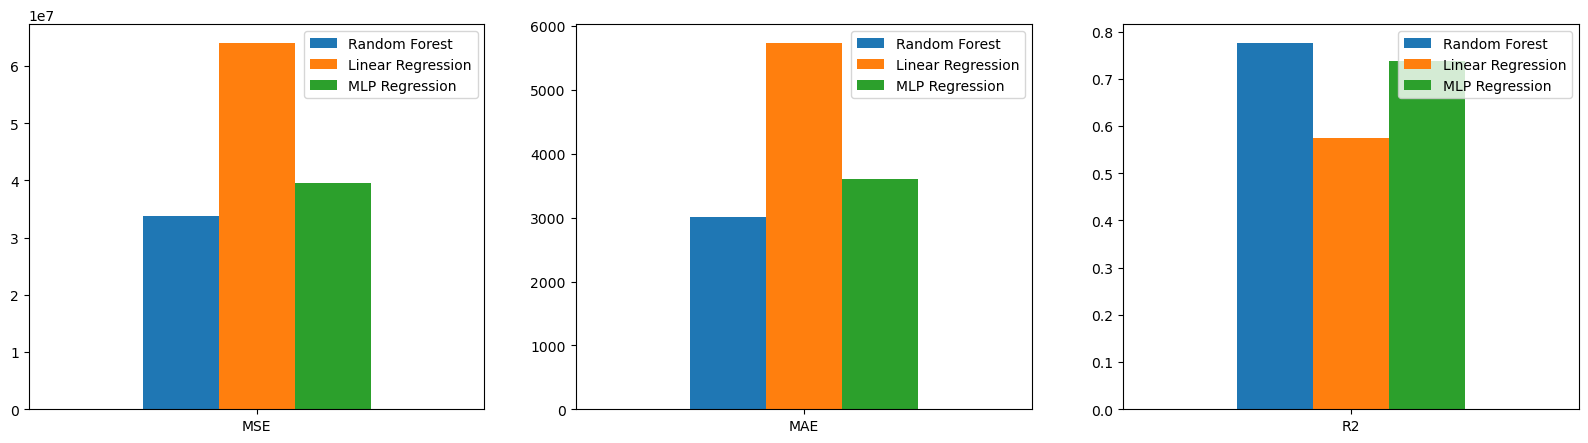

In [31]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'MLP Regression': MLP_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'MLP Regression': MLP_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'MLP Regression': MLP_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

## Question: How do Random Forest and Linear Regression compare on the insurance dataset?
RandomForest Regression: Best CV score = 0.872
Linear Regression: Best CV score = 0.702:
MLP Regression: Best CV score = 0.823

First of all to note, these are all pretty good results.


Which additional regressor have you used (or intend to use)? How does it compare to Random Forest and Linear Regression?
I have used MLP regression so I would have more options to explore. The results were initially poor in comparison to the other two techniques but it seemed marginally better than Random Forest in both MSE and MAE scores. This may be down to the grid params which I have chosen, and my choice of dimensionality Reduction. After a few iterations it is on par with RandomForest Regression, the best performing model.

Which parameters of the regressors have you explored and what are the results?
For the RandomForestRegressor I have explored N_FEATURES from 1 up to the maximum number of features I have in the dataset. I also explored the Max_depth options, varying it from 2 up to 8.
For Linear Regression I explored the binary parameter
FIT_INTERCEPT_OPTIONS = [False, True].


What other dimensionality reduction methods have you tried (or intend to try) and what are the results?
I have tried N_Features, or reducing the features in the grid search for all three methods, as well as PCA and RFE as was given in the example. I intend to explore varying them more in the coming week, as well as further exploration into the hyperparameters (the number of layers in particular) in the MLP regression, as I feel the model is performing more poor than I would have expected.


## Train the Final Model

In [32]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

## is R2 the most important? I feel like RandomForest is the best model performing across all three
pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regression__')))


final_model =pipe.fit(X, y)

In [33]:
# if needed later
import pickle

filename = 'final_modelregression.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Summarise your experience in a markdown cell 

RandomForest Regression is giving the lowest error measures for MSE/MAE with MLP Regression very close behind it. Linear Regression has the highest MSE/MAE scores and in addition has the lowest R2 score, by a significant bit. It also scored the lowest in the accuracy scores, so I would not recommend it as a good model based on the analysis I have completed. I suspect if I scaled and transformed the data differently I would have achieved better scores, with scores closer to 0.95 possible I suspect, especially after reading other students contributions.

I have ran through the various grid searches a number of times to try and get the best results that I can get, and explore feature selection by dropping some features altogether from the pipeline like in the Classification Task.

I am happy with the results achieved and the best model to hand.